# Imports

In [165]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import lovely_tensors as lt
lt.monkey_patch()

# AKD

In [7]:
class AdaptiveKD(torch.nn.Module):

    def __init__(self,norm_type='none',divergence='mse',temperature=1.0, k=0.5):
        super(AdaptiveKD, self).__init__()
       
        self.temperature = temperature
        self.k = k

        # define loss function
        if divergence == 'mse':
            self.criterion = torch.nn.MSELoss(reduction='sum')
        elif divergence == 'kl':
            self.criterion = torch.nn.KLDivLoss(reduction='sum')
            self.temperature = temperature
        self.divergence = divergence

    def forward(self, t_log, s_log, lab, verbose=False):
        
        n, c, h, w = t_log.shape
        
        lab = F.interpolate(lab[:,None,...].float(), (h,w), mode='bilinear', align_corners=True).long()
        t_lab = torch.argmax(t_log, axis=1, keepdims=True) 
        
        mask = torch.eq(t_lab, lab)
        if verbose:
            print(f'{mask=}')
            plt.imshow(mask[0,0,...,None])
            plt.show()
        gt_log = torch.nn.functional.one_hot(lab[:,0,...])[...,:c]
        gt_log = torch.permute(gt_log, (0, 3, 1, 2))
        
        t_log_masked = (self.k * t_log + (1 - self.k) * gt_log) * mask + gt_log * ~mask
        if verbose:
            print(f'{t_log_masked=}')
            plt.imshow(np.transpose(t_log_masked, (0,2,3,1))[0])
            plt.show()

        t_log_masked = t_log_masked.reshape((n,c,-1))
        s_log = s_log.reshape((n,c,-1))
        
        t_soft_masked = t_log_masked.softmax(dim=-1)
        s_soft = s_log.softmax(dim=-1)
        
        if verbose:
            print(f'{t_log=}')
            plt.imshow(np.transpose(t_log, (0,2,3,1))[0])
            plt.show()
        
            print(f'{gt_log=}')
            plt.imshow(np.transpose(gt_log, (0,2,3,1))[0]*255)
            plt.show()    
        
        if self.divergence == 'kl':
            s_soft = s_soft.log()
        loss = self.criterion(s_soft,t_soft_masked)
        loss /= n * c
        
        return loss * (self.temperature**2)

In [19]:
N = 19
W = H = 65
WL = HL = 512
B = 16

In [20]:
n = AdaptiveKD(k=0.9, divergence='kl')

In [24]:
t_log = np.random.uniform(size=(B,N,W,H))
s_log = np.random.uniform(size=(B,N,W,H))

lab = np.random.randint(0,255,size=(B,WL,HL))

t_log = torch.from_numpy(t_log)
s_log = torch.from_numpy(s_log)
lab = torch.from_numpy(lab)

t_log, s_log, lab

(tensor[16, 19, 65, 65] f64 n=1284400 x∈[1.476e-06, 1.000] μ=0.500 σ=0.289,
 tensor[16, 19, 65, 65] f64 n=1284400 x∈[3.461e-07, 1.000] μ=0.500 σ=0.289,
 tensor[16, 512, 512] i64 n=4194304 x∈[0, 254] μ=127.025 σ=73.605)

In [25]:
%timeit out = n(t_log.cuda(), s_log.cuda(), lab.cuda())

9.49 ms ± 155 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
out

tensor f64 cuda:0 0.041

# PSPNet

In [4]:
from networks.pspnet import Res_pspnet, BasicBlock, Bottleneck

In [5]:
s = Res_pspnet(BasicBlock, [2, 2, 2, 2], num_classes = 21)
t = Res_pspnet(Bottleneck, [3, 4, 23, 3], num_classes = 21)

In [6]:
print(s)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): InPlaceABNSync(64, eps=1e-05, momentum=0.1, affine=True, activation=identity)
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): InPlaceABNSync(64, eps=1e-05, momentum=0.1, affine=True, activation=identity)
  (relu2): ReLU()
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): InPlaceABNSync(128, eps=1e-05, momentum=0.1, affine=True, activation=identity)
  (relu3): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True)
  (relu): ReLU()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): InPlaceABNSync(64, eps=1e-05, momentum=0.1, affine=True, activation=identity)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stri

In [7]:
next(s.pspmodule.parameters()).shape

torch.Size([128, 512, 1, 1])

In [8]:
next(s.head.parameters()).shape

torch.Size([21, 128, 1, 1])

In [9]:
next(t.pspmodule.parameters()).shape

torch.Size([512, 2048, 1, 1])

In [10]:
next(t.head.parameters()).shape

torch.Size([21, 512, 1, 1])

In [11]:
w = './ckpt/train_epoch_50.pth'

In [14]:
weights = torch.load(w)

In [15]:
weights.keys()

dict_keys(['epoch', 'state_dict', 'optimizer'])

In [16]:
weights['state_dict']

OrderedDict([('module.layer0.0.weight',
              tensor[64, 3, 3, 3] n=1728 x∈[-0.947, 0.786] μ=-0.003 σ=0.155 cuda:0),
             ('module.layer0.1.weight',
              tensor[64] x∈[-0.075, 0.557] μ=0.139 σ=0.157 cuda:0),
             ('module.layer0.1.bias',
              tensor[64] x∈[-0.678, 0.437] μ=0.036 σ=0.247 cuda:0),
             ('module.layer0.1.running_mean',
              tensor[64] x∈[-0.073, 0.072] μ=0.006 σ=0.028 cuda:0),
             ('module.layer0.1.running_var',
              tensor[64] x∈[6.127e-15, 1.381] μ=0.249 σ=0.336 cuda:0),
             ('module.layer0.1.num_batches_tracked', tensor i64 cuda:0 33050),
             ('module.layer0.3.weight',
              tensor[64, 64, 3, 3] n=36864 x∈[-0.754, 0.805] μ=4.799e-05 σ=0.037 cuda:0),
             ('module.layer0.4.weight',
              tensor[64] x∈[-0.241, 0.546] μ=0.156 σ=0.190 cuda:0),
             ('module.layer0.4.bias',
              tensor[64] x∈[-0.572, 0.543] μ=0.064 σ=0.190 cuda:0),
        

In [17]:
from networks.pspnet import Res_pspnet, BasicBlock, Bottleneck, TransferConv

In [18]:
m = Res_pspnet(Bottleneck, [3, 4, 23, 3], num_classes = 20)

In [19]:
m.state_dict()

OrderedDict([('conv1.weight',
              tensor[64, 3, 3, 3] n=1728 x∈[-0.192, 0.192] μ=-0.003 σ=0.112),
             ('bn1.weight', tensor[64] x∈[1.000, 1.000] μ=1.000 σ=0.),
             ('bn1.bias', tensor[64] all_zeros),
             ('bn1.running_mean', tensor[64] all_zeros),
             ('bn1.running_var', tensor[64] x∈[1.000, 1.000] μ=1.000 σ=0.),
             ('bn1.num_batches_tracked', tensor i64 0),
             ('conv2.weight',
              tensor[64, 64, 3, 3] n=36864 x∈[-0.042, 0.042] μ=-0.000 σ=0.024),
             ('bn2.weight', tensor[64] x∈[1.000, 1.000] μ=1.000 σ=0.),
             ('bn2.bias', tensor[64] all_zeros),
             ('bn2.running_mean', tensor[64] all_zeros),
             ('bn2.running_var', tensor[64] x∈[1.000, 1.000] μ=1.000 σ=0.),
             ('bn2.num_batches_tracked', tensor i64 0),
             ('conv3.weight',
              tensor[128, 64, 3, 3] n=73728 x∈[-0.042, 0.042] μ=6.129e-05 σ=0.024),
             ('bn3.weight', tensor[128] x∈[1.000, 

In [28]:
a = torch.rand((1,3,224,224))

In [31]:
m.eval()

with torch.no_grad():
    out = m(a)

In [32]:
out

[tensor[1, 20, 29, 29] n=16820 x∈[-0.055, 0.069] μ=0.010 σ=0.024,
 tensor[1, 20, 29, 29] n=16820 x∈[-0.083, 0.137] μ=0.021 σ=0.058,
 tensor[1, 2048, 29, 29] n=1722368 x∈[0., 0.489] μ=0.065 σ=0.079,
 tensor[1, 512, 29, 29] n=430592 x∈[-0.001, 0.147] μ=0.017 σ=0.026]

In [33]:
430592 * 2e-9

0.0008611840000000001

In [ ]:
8e-4

# PascalVOC

In [23]:
from PIL import Image

In [73]:
m = Image.open('../../CIRKD/data/PascalVOC/SegmentationClass/2007_000042.png')
m = Image.open('../../CIRKD/data/Cityscapes/gtFine/train/aachen/aachen_000000_000019_gtFine_color.png')

In [65]:
i = Image.open('../../CIRKD/data/PascalVOC/JPEGImages/2007_000042.jpg')
i = Image.open('../../CIRKD/data/Cityscapes/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png')

In [66]:
from lovely_numpy import lo

In [74]:
n = np.array(m)

In [77]:
lo(n[...,0])

array[1024, 2048] u8 n=2097152 x∈[0, 255] μ=102.483 σ=46.538

(array([[1024.,    0.,    0., ...,    0.,    0.,    0.],
        [1024.,    0.,    0., ...,    0.,    0.,    0.],
        [1024.,    0.,    0., ...,    0.,    0.,    0.],
        ...,
        [1024.,    0.,    0., ...,    0.,    0.,    0.],
        [1024.,    0.,    0., ...,    0.,    0.,    0.],
        [1024.,    0.,    0., ...,    0.,    0.,    0.]]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 2048 BarContainer objects>)

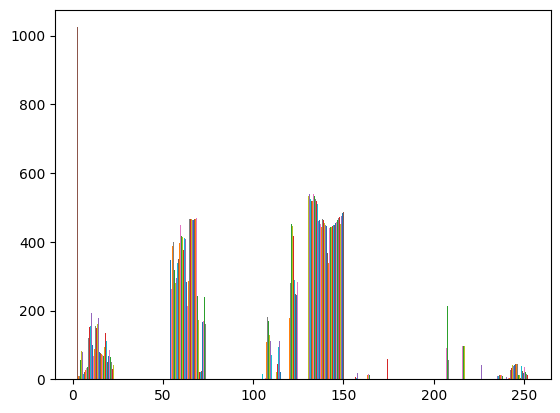

In [78]:
plt.hist(n[...,0])

In [ ]:
lo(n[n<225])

In [80]:
from dataset.datasets import CSTrainValSet, VOCDataSet

In [103]:
train_dataset = VOCDataSet('../../CIRKD/data/PascalVOC/', 
                           '../../CIRKD/data/PascalVOC/ImageSets/Segmentation/train.txt', 
                           max_iters=40000, crop_size=(255,255),
                           scale=1, mirror=True)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=False, num_workers=24, pin_memory=False)

In [97]:
train_dataset = CSTrainValSet('../../CIRKD/data/Cityscapes/', 
                              './dataset/list/cityscapes/train.lst', 
                              max_iters=40000, crop_size=(255,255),
                              scale=1, mirror=True)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=False, num_workers=24, pin_memory=False)

tensor[255, 255] n=65025 x∈[0., 220.000] μ=33.908 σ=71.576


(array([[230.,  13.,   0., ...,   0.,   0.,  12.],
        [230.,  13.,   0., ...,   0.,   0.,  12.],
        [230.,  13.,   0., ...,   0.,   0.,  12.],
        ...,
        [255.,   0.,   0., ...,   0.,   0.,   0.],
        [255.,   0.,   0., ...,   0.,   0.,   0.],
        [255.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([  0.,  22.,  44.,  66.,  88., 110., 132., 154., 176., 198., 220.]),
 <a list of 255 BarContainer objects>)

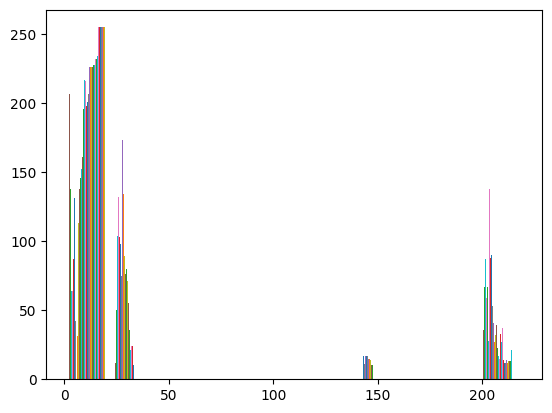

In [104]:
for x in trainloader:
    print(x[1][0])
    break
plt.hist(x[1][0])

# IFVD

In [2]:
class CriterionIFV(nn.Module):
    
    def __init__(self, classes):
        super(CriterionIFV, self).__init__()
        self.num_classes = classes

    def forward(self, preds_S, preds_T, target):
        feat_S = preds_S # features
        feat_T = preds_T # features
        feat_T.detach()
        size_f = (feat_S.shape[2], feat_S.shape[3]) # H, W
        tar_feat_S = nn.Upsample(size_f, mode='nearest')(target.unsqueeze(1).float()).expand(feat_S.size()) # rescale label
        tar_feat_T = nn.Upsample(size_f, mode='nearest')(target.unsqueeze(1).float()).expand(feat_T.size()) # rescale label
        center_feat_S = feat_S.clone()
        center_feat_T = feat_T.clone()
        print(tar_feat_S.shape)
        for i in range(self.num_classes):
            mask_feat_S = (tar_feat_S == i).float() # binary mask
            mask_feat_T = (tar_feat_T == i).float() # binary mask
            print(mask_feat_S.shape)
            center_feat_S = (1 - mask_feat_S) * center_feat_S + mask_feat_S * ((mask_feat_S * feat_S).sum(-1).sum(-1) / (mask_feat_S.sum(-1).sum(-1) + 1e-6)).unsqueeze(-1).unsqueeze(-1) # compute center
            center_feat_T = (1 - mask_feat_T) * center_feat_T + mask_feat_T * ((mask_feat_T * feat_T).sum(-1).sum(-1) / (mask_feat_T.sum(-1).sum(-1) + 1e-6)).unsqueeze(-1).unsqueeze(-1) # compute center

        print(center_feat_S.shape)
        # cosinesimilarity along C
        cos = nn.CosineSimilarity(dim=1)
        pcsim_feat_S = cos(feat_S, center_feat_S)
        pcsim_feat_T = cos(feat_T, center_feat_T)

        # mseloss
        mse = nn.MSELoss()
        loss = mse(pcsim_feat_S, pcsim_feat_T)
        return loss

In [3]:
class ContrastiveLoss(nn.Module):
    """
    Constrastive loss for features-matching clustering ispired by ArXiv:2002.05709
    """
    def __init__(self, batch_size, weight=0.1, temperature=0.1, name='cluster_loss'):
        super().__init__(name=name)
        self.contrastive_labels = tf.range(batch_size)
        self.weight = weight
        self.temperature = temperature
        self.cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, 
                                                                 reduction=tf.keras.losses.Reduction.NONE)
        self.reduction = tf.keras.losses.Reduction.SUM
        
    def call(self, y_pred, y_pred_):
        B, H, W, C = y_pred.shape
        y_pred = tf.reshape(y_pred, (B, H*W*C))
        y_pred_ = tf.reshape(y_pred_, (B, H*W*C))
        projections_1 = tf.math.l2_normalize(y_pred, axis=1)
        projections_2 = tf.math.l2_normalize(y_pred_, axis=1)
        similarities = (
            tf.matmul(projections_1, projections_2, transpose_b=True) / self.temperature
        )
        # The temperature-scaled similarities are used as logits for cross-entropy
        # a symmetrized version of the loss is used here
        loss_1_2 = self.cce(self.contrastive_labels, similarities)
        loss_2_1 = self.cce(self.contrastive_labels, tf.transpose(similarities))
        
        return (tf.reduce_sum(loss_1_2) + tf.reduce_sum(loss_2_1)) / 2 * self.weight

NameError: name 'tf' is not defined

In [4]:
sf = torch.rand((1, 2, 8, 8))
tf = torch.rand((1, 4, 8, 8))

m = torch.randint(0, 19, (1,8,8))

In [5]:
c = CriterionIFV(21)

In [6]:
l = c(sf, tf, m)

torch.Size([1, 2, 8, 8])
torch.Size([1, 2, 8, 8])
torch.Size([1, 2, 8, 8])
torch.Size([1, 2, 8, 8])
torch.Size([1, 2, 8, 8])
torch.Size([1, 2, 8, 8])
torch.Size([1, 2, 8, 8])
torch.Size([1, 2, 8, 8])
torch.Size([1, 2, 8, 8])
torch.Size([1, 2, 8, 8])
torch.Size([1, 2, 8, 8])
torch.Size([1, 2, 8, 8])
torch.Size([1, 2, 8, 8])
torch.Size([1, 2, 8, 8])
torch.Size([1, 2, 8, 8])
torch.Size([1, 2, 8, 8])
torch.Size([1, 2, 8, 8])
torch.Size([1, 2, 8, 8])
torch.Size([1, 2, 8, 8])
torch.Size([1, 2, 8, 8])
torch.Size([1, 2, 8, 8])
torch.Size([1, 2, 8, 8])
torch.Size([1, 2, 8, 8])


In [7]:
print(l)

tensor(0.0135)


# DKD

In [170]:
class CriterionDKD(nn.Module):

    def __init__(self, norm='space', alpha=1.0, beta=8.0, temperature=4.0, eps=1e-5):
        super(CriterionDKD, self).__init__()
       
        # define normalize function
        self.norm = norm
        self.temperature = temperature
        self.alpha = alpha
        self.beta = beta
        self.eps = eps
        # define loss function
        self.criterion = nn.KLDivLoss(reduction='sum')
 

    def forward(self, preds_S, preds_T, target):

        h, w = target.size(1), target.size(2)
        preds_S = F.interpolate(preds_S, size=(h, w), mode='bilinear', align_corners=True)
        preds_T = F.interpolate(preds_T, size=(h, w), mode='bilinear', align_corners=True)
        
        n,c,h,w = preds_S.shape
        
        target = self._ignore_index(target)
        
        loss_dkd = self.dkd_loss(preds_S.reshape((n,c,-1)), preds_T.reshape((n,c,-1)), target.reshape((n,-1)),
                                 self.norm, self.alpha, self.beta, self.temperature)
        return loss_dkd
    
    
    def dkd_loss(self, logits_student, logits_teacher, target, norm, alpha, beta, temperature):
        gt_mask = self._get_gt_mask(logits_student, target)
        other_mask = self._get_other_mask(logits_student, target)
        
        pred_student = F.softmax(logits_student / temperature, dim=1 if norm == 'space' else 1) # good
        pred_teacher = F.softmax(logits_teacher / temperature, dim=1 if norm == 'space' else 1) # good
        pred_student = self.cat_mask(pred_student, gt_mask, other_mask, ax=1 if norm == 'space' else 1)
        pred_teacher = self.cat_mask(pred_teacher, gt_mask, other_mask, ax=1 if norm == 'space' else 1)
        
        log_pred_student = torch.log(pred_student + self.eps)
        
        tckd_loss = F.kl_div(log_pred_student, pred_teacher, reduction='sum')
        tckd_loss *= (temperature**2) / pred_teacher.shape[0]
        tckd_loss /= pred_teacher.shape[-1] if norm == 'space' else pred_teacher.shape[-1]            
            
        pred_teacher_part2 = F.softmax(
            logits_teacher / temperature - 1000.0 * gt_mask, dim=1 if norm == 'space' else 2)
        log_pred_student_part2 = F.log_softmax(
            logits_student / temperature - 1000.0 * gt_mask, dim=1 if norm == 'space' else 2)
               
        nckd_loss = F.kl_div(log_pred_student_part2, pred_teacher_part2, reduction='sum')
        nckd_loss *= (temperature**2) / pred_teacher_part2.shape[0]
        nckd_loss /= pred_teacher_part2.shape[-1] if norm == 'space' else pred_teacher_part2.shape[-2]
        
        return alpha * tckd_loss + beta * nckd_loss

    
    def _ignore_index(self, target, index=255, n_classes=19):
        return torch.clamp(target, 0, n_classes)
        
        
    def _get_gt_mask(self, logits, target): # sequential target coding (B)
        n, c, hw = logits.shape
        mask = torch.zeros((n, c+1, hw)).scatter_(1, target.unsqueeze(1), 1).bool()
        return mask[:,:-1,...]


    def _get_other_mask(self, logits, target):
        n, c, hw = logits.shape
        mask = torch.ones((n, c+1, hw)).scatter_(1, target.unsqueeze(1), 0).bool()
        return mask[:,:-1,...]


    def cat_mask(self, t, mask1, mask2, ax):
        t1 = (t * mask1).sum(ax, keepdims=True)
        t2 = (t * mask2).sum(ax, keepdims=True)
        rt = torch.cat([t1, t2], dim=ax)
        return rt

In [186]:
lt = torch.rand((8, 19, 65, 65))*10
ls = torch.rand((8, 19, 65, 65))*10
lab = torch.zeros((8, 512, 512))
lab = torch.randint_like(lab, 0, 19, dtype=torch.int64)
lab[0,0,0] = 255

In [187]:
loss = CriterionDKD(alpha=1, beta=1, temperature=4, norm='space', eps=1e-9)

In [188]:
loss(ls, lt, lab)

tensor[8, 2, 262144] n=4194304 x∈[-20.723, 0.] μ=-1.554 σ=1.536
tensor 0.188
tensor 3.373


tensor 3.561

# Cityscapes Domains

**Train Domains (18)**

*Big*

hamburg (1.79 M),

cologne (1.06 M),

stuttgart (625 k),

dusseldorf (610 k),

bremen (563 k),

hanover (536 k),


*Medium*

zurich (415 k)

bochum (363 k),

strasbourg (291 k),

monchengladbach (261 k),

aachen (249 k),

krefeld (227 k),


*Small*

erfurt (213 k),

darmstadt (159 k),

ulm (127 k),

jena (111 k),

tubingen (108 k),

weimar (65 k),


**Validation Domains (3)**

frankfurt (733 k),

munster (318 k)

lindau (26 k),


**Test Domains (6)**

berlin (3.52 M),

munich (1.45 M),

bielefeld (334 k),

bonn (332 k),

mainz (218 k),

leverkusen (164 k),

In [15]:
import logging
import torch
from torch.utils import data
import os.path as osp
import numpy as np
import random
import cv2

In [16]:
class CSTrainValSet(data.Dataset):
    def __init__(self, root, list_path, max_iters=None, crop_size=(321, 321),
                 scale=True, mirror=True, ignore_label=255, domain=None):
        
        self.root = root
        self.list_path = list_path
        self.crop_h, self.crop_w = crop_size
        self.is_scale = scale
        self.is_mirror = mirror
        self.ignore_label = ignore_label
        self.img_ids = [i_id.strip().split() for i_id in open(list_path)]
        if max_iters:
            self.img_ids = self.img_ids * int(np.ceil(float(max_iters) / len(self.img_ids)))
            self.img_ids = self.img_ids[:max_iters]
            
        self.id_to_trainid = {-1: ignore_label, 0: ignore_label, 1: ignore_label, 2: ignore_label,
                              3: ignore_label, 4: ignore_label, 5: ignore_label, 6: ignore_label,
                              7: 0, 8: 1, 9: ignore_label, 10: ignore_label, 11: 2, 12: 3, 13: 4,
                              14: ignore_label, 15: ignore_label, 16: ignore_label, 17: 5,
                              18: ignore_label, 19: 6, 20: 7, 21: 8, 22: 9, 23: 10, 24: 11, 25: 12,
                              26: 13, 27: 14, 28: 15, 29: ignore_label, 30: ignore_label, 31: 16,
                              32: 17, 33: 18}
        
        self.domains = {'L': ['hamburg', 'cologne', 'stuttgart', 'dusseldorf', 'bremen', 'hanover'],
                        'M': ['zurich', 'bochum', 'strasbourg', 'monchengladbach', 'aachen', 'krefeld'],
                        'S': ['erfurt', 'darmstadt', 'ulm', 'jena', 'tubingen', 'weimar']}
            
        self.files = []
        for item in self.img_ids:
            image_path, label_path = item
            name = osp.splitext(osp.basename(label_path))[0]
            city = name.split('_')[0]
            img_file = osp.join(self.root, image_path)
            label_file = osp.join(self.root, label_path)
            if not domain or city in self.domains[domain]:
                self.files.append({"img": img_file,
                                   "label": label_file,
                                   "name": name})
        
        logging.info('{} images are loaded!'.format(len(self.img_ids)))

    def __len__(self):
        return len(self.files)

    def generate_scale_label(self, image, label):
        f_scale = 0.7 + random.randint(0, 14) / 10.0
        image = cv2.resize(image, None, fx=f_scale, fy=f_scale, interpolation = cv2.INTER_LINEAR)
        label = cv2.resize(label, None, fx=f_scale, fy=f_scale, interpolation = cv2.INTER_NEAREST)
        return image, label

    def id2trainId(self, label, reverse=False):
        label_copy = label.copy()
        if reverse:
            for v, k in self.id_to_trainid.items():
                label_copy[label == k] = v
        else:
            for k, v in self.id_to_trainid.items():
                label_copy[label == k] = v
        return label_copy

    def __getitem__(self, index):
        datafiles = self.files[index]
        image = cv2.imread(datafiles["img"], cv2.IMREAD_COLOR)
        label = cv2.imread(datafiles["label"], cv2.IMREAD_GRAYSCALE)
        label = self.id2trainId(label)
        size = image.shape
        name = datafiles["name"]
        if self.is_scale:
            image, label = self.generate_scale_label(image, label)
        image = np.asarray(image, np.float32)
        image = image - np.array([104.00698793, 116.66876762, 122.67891434])
        img_h, img_w = label.shape
        pad_h = max(self.crop_h - img_h, 0)
        pad_w = max(self.crop_w - img_w, 0)
        if pad_h > 0 or pad_w > 0:
            img_pad = cv2.copyMakeBorder(image, 0, pad_h, 0, 
                pad_w, cv2.BORDER_CONSTANT, 
                value=(0.0, 0.0, 0.0))
            label_pad = cv2.copyMakeBorder(label, 0, pad_h, 0, 
                pad_w, cv2.BORDER_CONSTANT,
                value=(self.ignore_label,))
        else:
            img_pad, label_pad = image, label
        img_h, img_w = label_pad.shape
        h_off = random.randint(0, img_h - self.crop_h)
        w_off = random.randint(0, img_w - self.crop_w)
        image = np.asarray(img_pad[h_off : h_off+self.crop_h, w_off : w_off+self.crop_w], np.float32)
        label = np.asarray(label_pad[h_off : h_off+self.crop_h, w_off : w_off+self.crop_w], np.float32)
        image = image.transpose((2, 0, 1))
        if self.is_mirror:
            flip = np.random.choice(2) * 2 - 1
            image = image[:, :, ::flip]
            label = label[:, ::flip]
        return image.copy(), label.copy(), np.array(size), name

In [17]:
class CSTestSet(data.Dataset):
    def __init__(self, root, list_path, crop_size=(321, 321)):
        self.root = root
        self.list_path = list_path
        self.crop_h, self.crop_w = crop_size
        self.img_ids = [i_id.strip().split() for i_id in open(list_path)]
        self.files = [] 
        for item in self.img_ids:
            image_path = item[0]
            name = osp.splitext(osp.basename(image_path))[0]
            img_file = osp.join(self.root, image_path)
            self.files.append({
                "img": img_file
            })

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        datafiles = self.files[index]
        image = cv2.imread(datafiles["img"], cv2.IMREAD_COLOR)
        size = image.shape
        name = osp.splitext(osp.basename(datafiles["img"]))[0]
        image = np.asarray(image, np.float32)
        image = image - np.array([104.00698793, 116.66876762, 122.67891434])
        img_h, img_w, _ = image.shape
        pad_h = max(self.crop_h - img_h, 0)
        pad_w = max(self.crop_w - img_w, 0)
        if pad_h > 0 or pad_w > 0:
            image = cv2.copyMakeBorder(image, 0, pad_h, 0, 
                pad_w, cv2.BORDER_CONSTANT, 
                value=(0.0, 0.0, 0.0))
        image = image.transpose((2, 0, 1)).astype(np.float32)
        return image, np.array(size), name


In [27]:
d = CSTrainValSet('../../CIRKD/data/Cityscapes/', './dataset/list/cityscapes/train.lst', domain='S')

INFO     2975 images are loaded!


In [28]:
len(d)

694

In [44]:
domains = ['L', 'M', 'S']
[d for d in domains if d != 'L']

['M', 'S']

In [52]:
w = torch.load('../../CWD/ckpt/teacher_city.pth')

In [53]:
w.keys()

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'conv2.weight', 'bn2.weight', 'bn2.bias', 'bn2.running_mean', 'bn2.running_var', 'conv3.weight', 'bn3.weight', 'bn3.bias', 'bn3.running_mean', 'bn3.running_var', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.conv3.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'la

In [1]:
import os
import warnings
#warnings.filterwarnings("ignore")

from options import TrainOptions
from utils.hp_search import HPSearcher
from utils.train_teacher import Trainer

import random
import numpy as np
import torch

In [2]:
args = TrainOptions().initialize()

if args.reproduce:   
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)

os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu

if args.hp_search:
    searcher = HPSearcher(args)
    searcher.hp_search()
else:
    trainer = Trainer(args)

usage: ipykernel_launcher.py [-h] [--local_rank LOCAL_RANK] [--gpu GPU]
                             [--dataset DATASET] [--num_classes NUM_CLASSES]
                             [--data_dir DATA_DIR] [--data_list DATA_LIST]
                             [--data_listval DATA_LISTVAL]
                             [--ignore_label IGNORE_LABEL]
                             [--input_size INPUT_SIZE] [--random_mirror]
                             [--random_scale] [--domain DOMAIN]
                             [--T_ckpt_path T_CKPT_PATH] [--S_resume S_RESUME]
                             [--S_ckpt_path S_CKPT_PATH] [--D_resume D_RESUME]
                             [--D_ckpt_path D_CKPT_PATH]
                             [--is_student_load_imgnet IS_STUDENT_LOAD_IMGNET]
                             [--student_pretrain_model_imgnet STUDENT_PRETRAIN_MODEL_IMGNET]
                             [--batch_size BATCH_SIZE] [--num_steps NUM_STEPS]
                             [--momentum MOMENTUM] [--p

S
1374450


INFO     1374450 images are loaded!
INFO     2975 images are loaded!


In [3]:
print(len(trainer.trainloader.dataset))

320628


In [4]:
trainer.args.num_steps*trainer.args.batch_size

320000

In [1]:
import torch

In [2]:
a = [torch.zeros((3,23,23)), torch.ones((3,23,23))]

In [4]:
t = torch.mean(torch.stack(a),dim=0)

In [5]:
t.shape

torch.Size([3, 23, 23])

# Shape Check

In [1]:
import torch
from networks.pspnet import Res_pspnet, Bottleneck
from networks.pspnet_old import BasicBlock, Res_pspnet as Res_pspnet_old
from networks.pspnet_new import PSPNet as Res_pspnet_new

In [3]:
teacher = Res_pspnet(Bottleneck, [3, 4, 23, 3]).eval().cuda()
#new = Res_pspnet_new(Bottleneck, [3, 4, 23, 3]).eval().cuda()
student = Res_pspnet_old(BasicBlock, [2, 2, 2, 2]).eval().cuda()

In [4]:
with torch.no_grad():
    x = torch.zeros((4,3,512,512)).cuda()
    yt = teacher(x)
    yt[0] = torch.nn.functional.interpolate(yt[0], (65,65), mode='bilinear', align_corners=True)

In [5]:
with torch.no_grad():
    x = torch.zeros((4,3,512,512)).cuda()
    ys = student(x)

In [6]:
[i.shape for i in yt]

[torch.Size([4, 21, 65, 65]),
 torch.Size([4, 21, 64, 64]),
 torch.Size([4, 2048, 64, 64]),
 torch.Size([4, 512, 64, 64])]

In [7]:
[i.shape for i in ys]

[torch.Size([4, 21, 65, 65]),
 torch.Size([4, 21, 65, 65]),
 torch.Size([4, 512, 65, 65]),
 torch.Size([4, 128, 65, 65])]